# Discovery of Diabetes in Pima Indians Population 

## Goal

The goal of this project was to construct the model for detection of diabetes type II based on the easily accessible data. 
The data is taken from female members of Pima Indians population, and consists of basic information on the patient, such as age, blood preassure, skin thickness, number of pregnancies, BMI and some laboratory tests such as plasma insulin content.
The task is to analyse the given dataset and construct models for the classification of patients with and without diabetes. Two different machine learning algorithms should be chosen. Given the number of missing data points, test the algorithm on both dataset without these values and the filled dataset. Use cross validation for the model evaluation and parameter tuning. 

## Content

This notebook is organised as followed:

&nbsp;1. Dataset overwiev   

&nbsp;2. Data preprocessing  
&nbsp;&nbsp;&nbsp;2.1. Missing values  
&nbsp;&nbsp;&nbsp;2.2. Data normalization

&nbsp;3. Models - SVM  
&nbsp;&nbsp;&nbsp;3.1. Linear SVM   
&nbsp;&nbsp;&nbsp;3.2. RBF   
&nbsp;&nbsp;&nbsp;3.3. Polynomial SVM   

&nbsp;4. Models - Random Forests classifier  

&nbsp;5. Results summary 

 __________________________________________________________________________________________________________________________________

## 1. Dataset Overview

First couple of cells represent the dataset overview - dataset shape and size, the features, their descriptions (max, min, mean, std and quantiles), and the label distribution. At this step, the high class imbalance can be noticed, with negative class being over-represented.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import neighbors
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Dataset preview and shape

os.chdir('F:\\BDMB_project')
data = pd.read_csv('diabetes.csv')
data.iloc[:, 1:8] = data.iloc[:, 1:8].replace(0, np.nan) # replace 0 (missing values) with np.nan
print('Shape of data is: ', data.shape)
data.head()


Shape of data is:  (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [3]:
# Descriptions of features

data.iloc[:,:-1].describe().round(decimals=2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.00,763.00,733.00,541.00,394.00,757.00,768.00,768.00
mean,3.85,121.69,72.41,29.15,155.55,32.46,0.47,33.24
std,3.37,30.54,12.38,10.48,118.78,6.92,0.33,11.76
min,0.00,44.00,24.00,7.00,14.00,18.20,0.08,21.00
25%,1.00,99.00,64.00,22.00,76.25,27.50,0.24,24.00
50%,3.00,117.00,72.00,29.00,125.00,32.30,0.37,29.00
75%,6.00,141.00,80.00,36.00,190.00,36.60,0.63,41.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00


count     768
unique      2
top         0
freq      500
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Label frequency distribution')

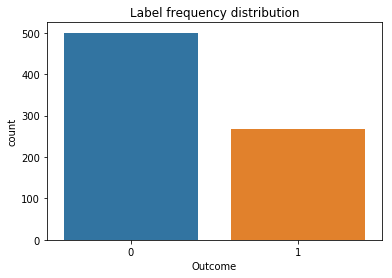

In [4]:
# Label distribution overview and class imabalance

print(data['Outcome'].astype('category').describe())
sns.countplot(data['Outcome'])
plt.title('Label frequency distribution')

In the next two cells, relationships between features are showed. 

The first plot represents a pairwise relationship between each feature, with the colorcoded outcome (label, blue - negative class, orange - positive class). Plots on the diagonal represent the distributions of the exact features, divided by the class. 
From this plot, it can concluded that not a single binary combiantion of features separates the data sufficiently for classification to be performed. Also, based on the plots on the diagonal, only features pregnancies, glucose, BMI and age show a different (yet overlapping) distributions for positive and negative classes, meaning that these features are discriminative. On the other side, feature representing blood preasure is a non-discriminative feature, since the distributions for both positive and negative class overlap.

Second plot represents the heatmap of the correlation between features. The color coding is represented in the legend. it is interesting to note the feature pairs with highest correlations - pregnancies and age, glucose and insulin, skin thickness and BMI. The high dependencies between these feature is intuitive and expected. 



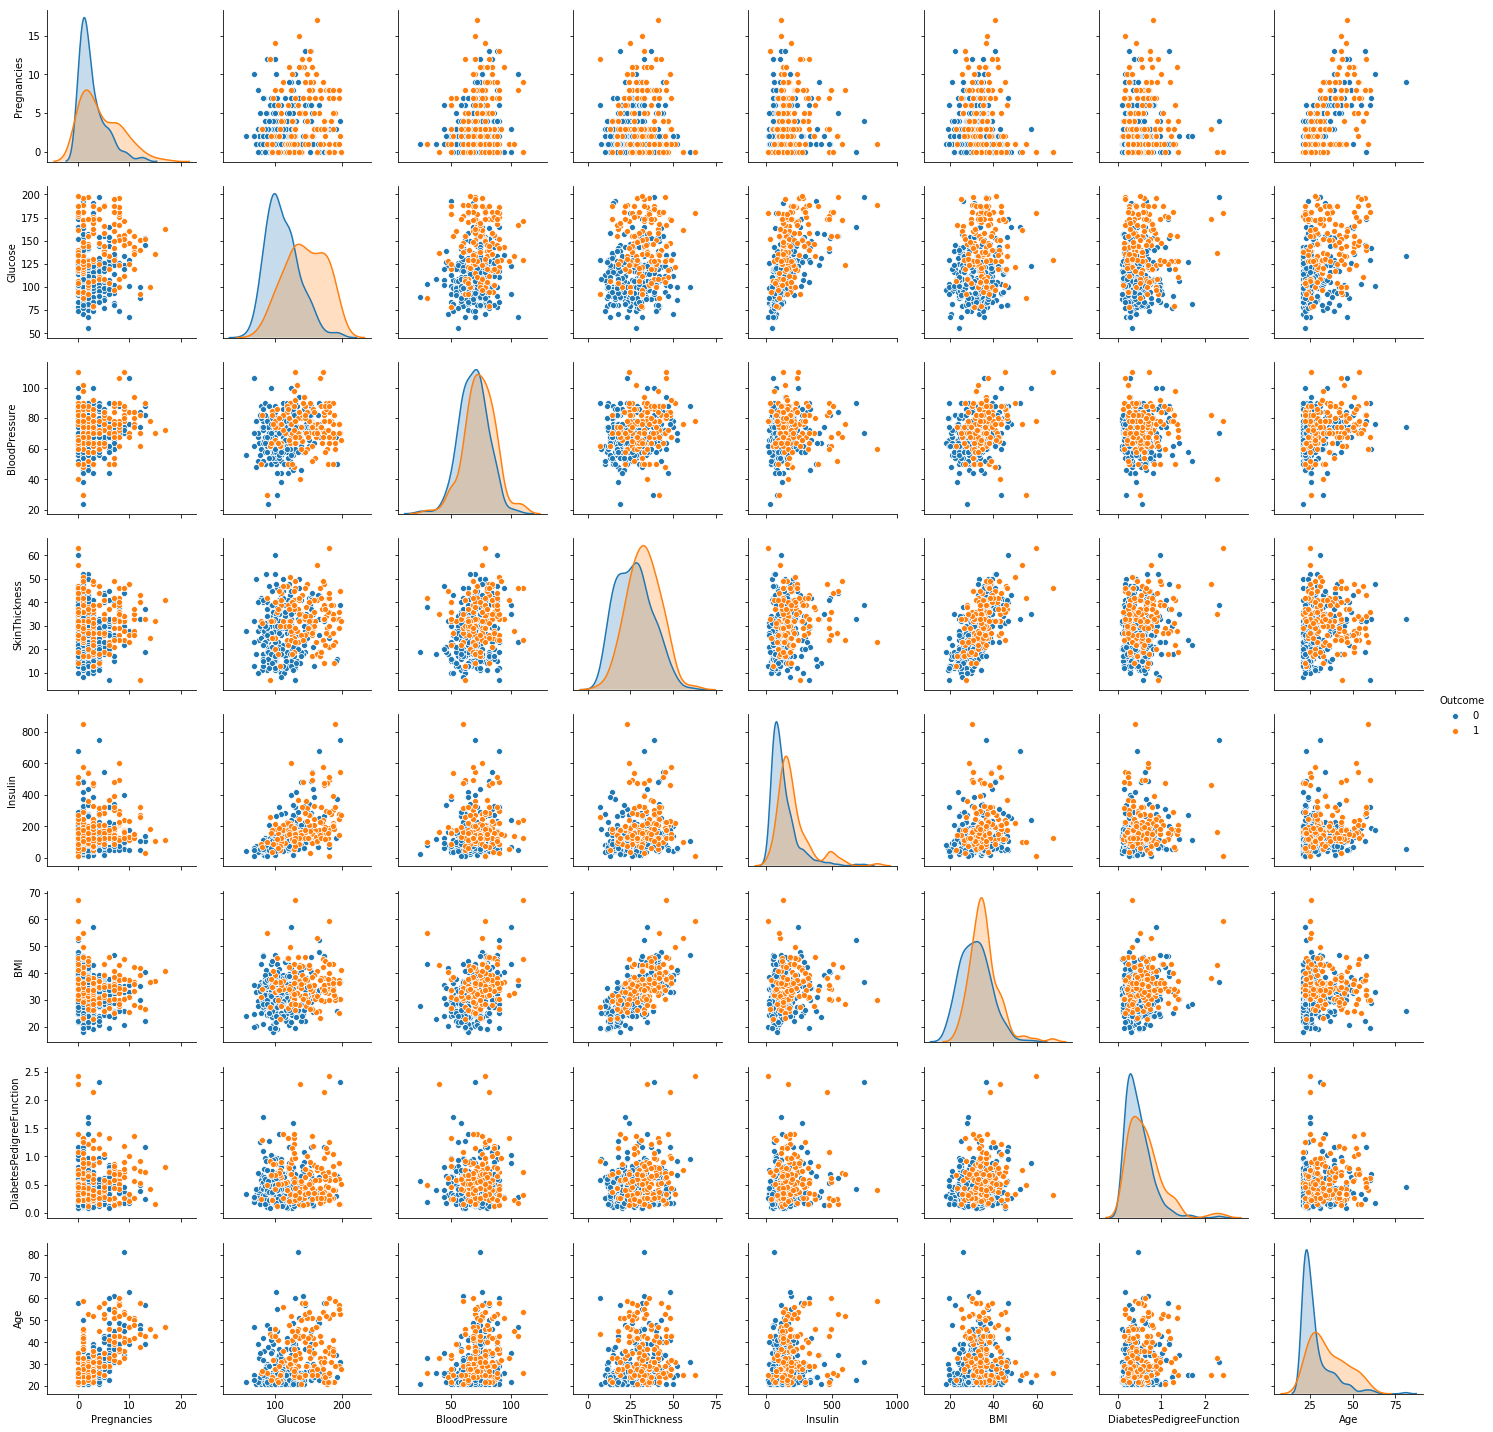

In [5]:
sns.pairplot(data.dropna(axis=0, how='any'), hue='Outcome', vars=data.columns.values[:-1])

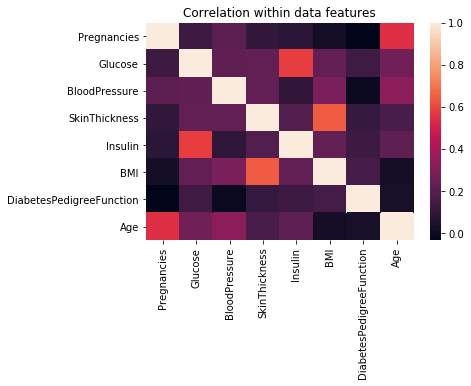

In [6]:
corr = data.iloc[:, :-1].corr()
sns.heatmap(corr)
plt.title('Correlation within data features')
plt.show()

## 2. Data preprocessing

### 2.1. Missing values

In the original dataset, the missing values are represented as zeros, and in this notebook they have been replaced with NaNs in all features except the number of pregnancies (since that would mean having no women with zero pregnancies). On the first plot, the numbers of NaNs per row are represented. Since there is 8 features, and most of the rows that have a missing value have 1, 2 or 3 of them, next two strategies were chosen:
1. "clean" - remove all rows with any missing values
2. "mean" - replace missing values with the column mean

When iputing the mean value, the original dataset was first split into a train and test set, the mean of train set was computed, and then the missing values of both sets were replaced with same values. In other words, missing values in the test set were replaced with the mean of the train set. 

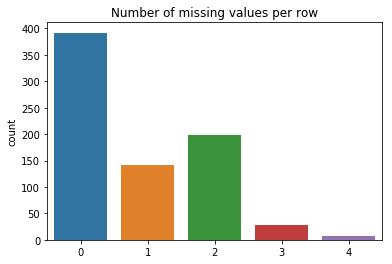

In [7]:
def count_nans(data_row):
    cnt = 0
    for value in data_row.iteritems():
        if np.isnan(value[1]) == True:
            cnt += 1
    return(cnt)

nan_number = []

for row in data.iterrows():
    nan_number.append(count_nans(row[1]))
    
sns.countplot(nan_number)
plt.title('Number of missing values per row')
plt.show()

In [8]:
# Makes a copy of original dataset and ecxcludes all rows which have a missing value

clean_data = data.copy()
clean_data = clean_data.dropna(axis=0, how='any')

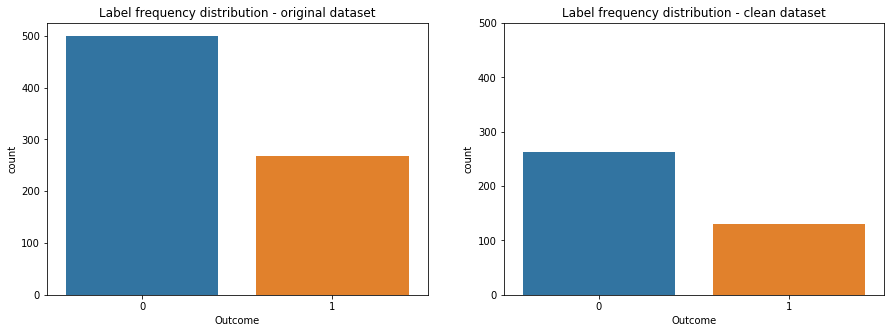

Zero to one ratio:

Original dataset:  1.8656716417910448
Clean dataset:  2.0153846153846153


In [9]:
# Significatn amount of data is being lost after all rows with missing values are excluded, but the class 
# ratio is being preserved

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Label frequency distribution - original dataset')
sns.countplot(data['Outcome'])
plt.subplot(122)
sns.countplot(clean_data['Outcome'])
plt.ylim(0, 500)
plt.title('Label frequency distribution - clean dataset')
plt.show()

print('Zero to one ratio:\n')
print('Original dataset: ', (data['Outcome'] == 0).sum()/(data['Outcome'] == 1).sum())
print('Clean dataset: ', (clean_data['Outcome'] == 0).sum()/(clean_data['Outcome'] == 1).sum())

In [10]:
# Train test split data for "clean" and "mean" strategies

X, y = clean_data.iloc[:,:-1], clean_data.iloc[:,-1]
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_mean, y_mean = data.iloc[:,:-1], data.iloc[:,-1]
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y_mean, test_size=0.2, 
                                                                        random_state=1, stratify=y_mean)

In [11]:
# Replacing the missing values of train and test sets with train data means

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean = imp.fit_transform(X_train_mean)
X_test_mean = imp.transform(X_test_mean)

### 2.1. Normalization

For the normalization part, the same strategy of separating train and test data was used. Mean and the standard deviation of the train set features was calculated, the mean was substracted from each value and that value was later divided with the standard deviation. The same procedure was repeated on the test data, using mean and std from train set. 
At the end of this step, all data had the mean removed, and was scaled to a unit variance.

In [13]:
# Scaling "clean" data
clean_scaler = StandardScaler(with_mean=True, with_std=True)
X_train_cl = clean_scaler.fit_transform(X_train_cl)
X_test_cl = clean_scaler.transform(X_test_cl)

# Scaling "mean" data
mean_scaler = StandardScaler(with_mean=True, with_std=True)
X_train_mean = mean_scaler.fit_transform(X_train_mean)
X_test_mean = mean_scaler.transform(X_test_mean)

## 3. Models - Support Vector Machines

### 3.1. Linear SVM

The first algorthm used to solve this problem was Support Vector Machines with a linear kernel. Data was split so that the test set was 20% of total data, and the 10 fold cross validation for parameter tuning was performed on the train data (other 80% of data). The value for C was chosen between [0.1, 1, 10, 50, 100], after fine tining the wider range of numbers. This procedure was repeated for both "clean" and "mean" datasets. The best estimator for both "clean" and "mean" was using C=10, and was further used for validating the model. The ROC curves are represented below. 

In [14]:
def onehot(labels):
    """
    Converts the original data labels 
    to one hot encoding, required for the 
    ROC plots
    """
    onehot_list = []
    try:
        for label in labels.iteritems():
            if label[1] == 1:
                onehot_list.append([0, 1])
            else:
                onehot_list.append([1, 0])
    except:
        for label in labels:
            if label == 1:
                onehot_list.append([0, 1])
            else:
                onehot_list.append([1, 0])

    return(np.array(onehot_list))

def plot_roc(y_true, y_pred_proba):
    """
    Function that plots the ROC curve
    when given the true labels and 
    predicted probabilities
    """
    y_true_bin = onehot(y_true)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - best estimator')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
def lin_svm(x_train, y_train, x_test, y_test):
        param_grid = {'C': [0.1, 1, 10, 50, 100]}
        grid = GridSearchCV(svm.LinearSVC(max_iter=1000), param_grid, cv=10)
        grid.fit(x_train, y_train)
        print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
        print('Best parameters: ', grid.best_params_)
        print('Best estimator: ', grid.best_estimator_)
        lr = grid.best_estimator_
        y_pred = lr.predict(x_test)
        print(classification_report(y_test, y_pred))

In [16]:
print('Linear SVM', '\n\nClean dataset:\n')
lin_svm(X_train_cl, y_train_cl, X_test_cl, y_test_cl)

Linear SVM 

Clean dataset:

Best cross-validation score: 0.81
Best parameters:  {'C': 50}
Best estimator:  LinearSVC(C=50, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
              precision    recall  f1-score   support

           0       0.75      0.87      0.81        53
           1       0.61      0.42      0.50        26

   micro avg       0.72      0.72      0.72        79
   macro avg       0.68      0.65      0.65        79
weighted avg       0.71      0.72      0.71        79



In [17]:
print('Linear SVM', '\n\nMean dataset:\n')
lin_svm(X_train_mean, y_train_mean, X_test_mean, y_test_mean)

Linear SVM 

Mean dataset:

Best cross-validation score: 0.77
Best parameters:  {'C': 0.1}
Best estimator:  LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       100
           1       0.74      0.48      0.58        54

   micro avg       0.76      0.76      0.76       154
   macro avg       0.75      0.70      0.71       154
weighted avg       0.76      0.76      0.74       154



### 3.1. RBF SVM

The second algorthm used to solve this problem was Support Vector Machines with a Gaussina kernel. The same train-test data split was used. The value for C was chosen between [0.1, 0.5, 1, 50, 10], after fine tining the wider range of numbers. This procedure was repeated for both "clean" and "mean" datasets. The best estimator for both "clean" and "mean" was using C=1, and was further used for validating the model. The ROC curves are represented below. 

In [18]:
def rbf_svm(x_train, y_train, x_test, y_test):
    param_grid = {'C': [0.1, 0.5, 1, 50, 10]}
    grid = GridSearchCV(svm.SVC(kernel='rbf', gamma=0.7, probability=True), param_grid, cv=10)
    grid.fit(x_train, y_train)
    print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
    print('Best parameters: ', grid.best_params_)
    print('Best estimator: ', grid.best_estimator_)
    lr = grid.best_estimator_
    y_pred = lr.predict(x_test)
    y_pred_proba = lr.predict_proba(x_test)
    print(classification_report(y_test, y_pred))
    print('\n\n\nConfusion matirx:\n', confusion_matrix(y_test.astype('int64'), y_pred))
    #return(y_pred_proba)
    plot_roc(y_test, y_pred_proba)
    

RBF SVM 

Clean dataset:

Best cross-validation score: 0.74
Best parameters:  {'C': 1}
Best estimator:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.71      0.91      0.79        53
           1       0.55      0.23      0.32        26

   micro avg       0.68      0.68      0.68        79
   macro avg       0.63      0.57      0.56        79
weighted avg       0.65      0.68      0.64        79




Confusion matirx:
 [[48  5]
 [20  6]]


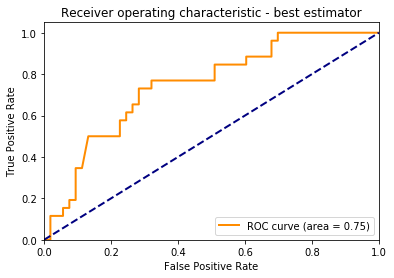

In [19]:
print('RBF SVM', '\n\nClean dataset:\n')
rbf_svm(X_train_cl, y_train_cl, X_test_cl, y_test_cl)

RBF SVM 

Mean dataset:

Best cross-validation score: 0.73
Best parameters:  {'C': 1}
Best estimator:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       100
           1       0.68      0.48      0.57        54

   micro avg       0.74      0.74      0.74       154
   macro avg       0.72      0.68      0.69       154
weighted avg       0.73      0.74      0.73       154




Confusion matirx:
 [[88 12]
 [28 26]]


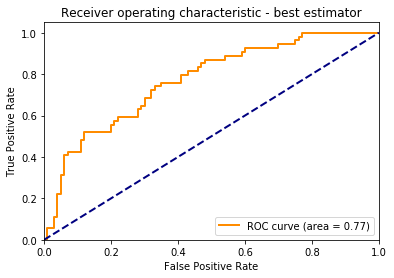

In [20]:
print('RBF SVM', '\n\nMean dataset:\n')
rbf_svm(X_train_mean, y_train_mean, X_test_mean, y_test_mean)

### Polynomial SVM

### 3.1. Polynomial SVM

The third algorthm used to solve this problem was Support Vector Machines with a polynomial kernel. The same train-test data split was used, with 10 fold cross validation parameter tuning strategy on train data. The value for C was chosen between [0.1, 0.5, 1, 50, 100], and the polynom degree was chosen from set [2, 3, 4, 5] after fine tuning the wider range of numbers. This procedure was repeated for both "clean" and "mean" datasets. The best estimator for both "clean" and "mean" was using C=0.5 and degree = 3, and was further used for validating the model. The ROC curves are represented below. 

In [21]:
def ply_svm(x_train, y_train, x_test, y_test):
    param_grid = {'C': [0.1, 0.5, 1, 50, 100],
                'degree': [2, 3, 4, 5]}
    grid = GridSearchCV(svm.SVC(kernel='poly', gamma='auto', probability=True), param_grid, cv=10)
    grid.fit(x_train, y_train)
    print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
    print('Best parameters: ', grid.best_params_)
    print('Best estimator: ', grid.best_estimator_)
    lr = grid.best_estimator_
    y_pred = lr.predict(x_test)
    y_pred_proba = lr.predict_proba(x_test)
    print(classification_report(y_test, y_pred))
    plot_roc(y_test, y_pred_proba)

Ploynomial SVM 

Clean dataset:

Best cross-validation score: 0.76
Best parameters:  {'C': 0.5, 'degree': 3}
Best estimator:  SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        53
           1       0.67      0.23      0.34        26

   micro avg       0.71      0.71      0.71        79
   macro avg       0.69      0.59      0.58        79
weighted avg       0.70      0.71      0.66        79



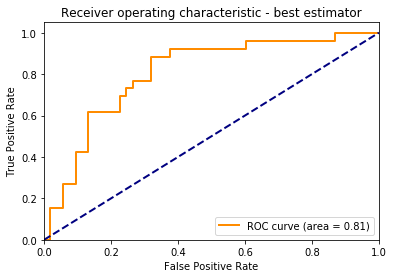

In [22]:
print('Ploynomial SVM', '\n\nClean dataset:\n')
ply_svm(X_train_cl, y_train_cl, X_test_cl, y_test_cl)

Ploynomial SVM 

Mean dataset:

Best cross-validation score: 0.71
Best parameters:  {'C': 0.1, 'degree': 3}
Best estimator:  SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       100
           1       0.82      0.26      0.39        54

   micro avg       0.72      0.72      0.72       154
   macro avg       0.77      0.61      0.61       154
weighted avg       0.75      0.72      0.67       154



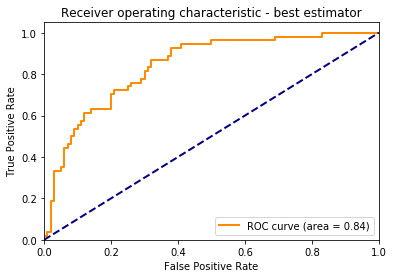

In [23]:
print('Ploynomial SVM', '\n\nMean dataset:\n')
ply_svm(X_train_mean, y_train_mean, X_test_mean, y_test_mean)

## 4. Random forests

The final algorthm used to solve this problem was Random forests. The same train-test data split was used, with 10 fold cross validation parameter tuning strategy on train data. The number of estimators was chosen between [10, 20, 30, 40, 50, 60, 70, 80], after fine tuning the wider range of numbers. This procedure was repeated for both "clean" and "mean" datasets. The best estimator for both "clean" and "mean" was using 50 estimators, and was further used for validating the model. The ROC curves are represented below. 

In [24]:
def rf(x_train, y_train, x_test, y_test):
    param_grid = {'n_estimators': list(range(10, 81, 10))}
    rf = RandomForestClassifier()
    grid = GridSearchCV(rf, param_grid, cv=10, scoring='roc_auc')
    grid.fit(x_train, y_train)
    print('Best cross-validation score: {:.2f}'.format(grid.best_score_))
    print('Best parameters: ', grid.best_params_)
    print('Best estimator: ', grid.best_estimator_)
    lr = grid.best_estimator_
    y_pred_proba = lr.predict_proba(x_test)
    y_pred = lr.predict(x_test)
    print(classification_report(y_test, y_pred))
    plot_roc(y_test, y_pred_proba)

Random forests 

Clean dataset:

Best cross-validation score: 0.86
Best parameters:  {'n_estimators': 60}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
              precision    recall  f1-score   support

           0       0.77      0.87      0.81        53
           1       0.63      0.46      0.53        26

   micro avg       0.73      0.73      0.73        79
   macro avg       0.70      0.66      0.67        79
weighted avg       0.72      0.73      0.72        79



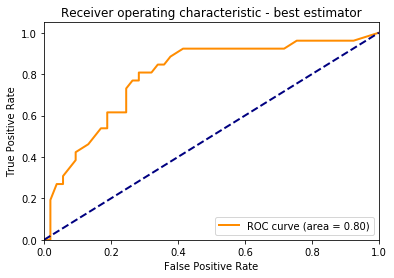

In [25]:
print('Random forests', '\n\nClean dataset:\n')
rf(X_train_cl, y_train_cl, X_test_cl, y_test_cl)

Random forests 

Mean dataset:

Best cross-validation score: 0.83
Best parameters:  {'n_estimators': 60}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

   micro avg       0.73      0.73      0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



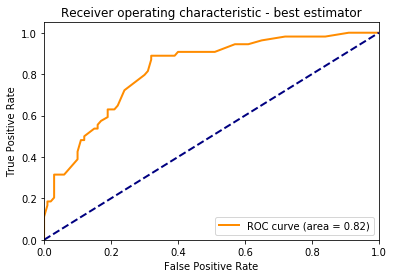

In [26]:
print('Random forests', '\n\nMean dataset:\n')
rf(X_train_mean, y_train_mean, X_test_mean, y_test_mean)

## 5. Results summary

Some of the results ar represented in the table below. The chosen metrics for model comparisons are macro precision, recall and F1 score, due to the class imbalance. 

| -  |  - | Linear SVM  | RBF SVM  | Polynomial SVM  | Random Forests  |
|:-:|:-:|:-:|:-:|:-:|:-:|
| clean  |  macro precision | 0.68  |0.63   |0.69   |0.7   |
| clean  | macro recall  | 0.65  | 0.57  |0.59   |**0.66**   |
| clean  | macro f1 score  | 0.65  | 0.56  | 0.58  |**0.67**   |
| clean  | area under ROC  | -  | 0.75  |0.81   |0.8   |
| mean  | macro precision  |  0.75 | 0.72  |**0.77**   |0.71   |
| mean  | macro recall  | **0.7**  | 0.68  | 0.69  | 0.69  |
| mean  | macro f1 score  | **0.71**  | 0.69  |0.69   | 0.69  |
| mean  | area under ROC  | -  | 0.77  |**0.84**   | 0.82  |

As can be seen from the table, "mean" stratiegy gives better results overall. 
Considering "clean" strategy only, the best model is Random Forest Classifier, with the largest precision, recall and F1 score. However, in the "mean" strategy, the results are more "tight" with Polynomial SVM having the highest precision, and Linear SVm having largest macro recall and F1 socre. Polynomial SVM has the largest area under ROC curve score in the "mean section".

## 6. Conclusion

In order to improve achieved results, several measures could be taken. First, in order for this data to be more confident, a nested cross validation could be performed, meaning that the process of testing and hyperparameter tuning could be repeated for 10 different folds. Further on, since from the results it is obvious that data imputation yields better results, more complex means of data imputation could be tested. Lastly, trying more complex machine learning algorithms could also contribute to better results.